In [1]:
import sys
import os

sys.path.insert(0, '/home/xiaojun/ssd_caffe/python')
import caffe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset_dir = 'dataset/'
label_file = dataset_dir + 'labels.csv'
train_set = dataset_dir + 'train/'
test_set = dataset_dir + 'test/'

In [3]:
if os.path.exists(label_file):
    df_csv = pd.read_csv(label_file)
else:
    print label_file, 'does not exist'

label_list = df_csv.as_matrix()
print 'label size: {}'.format(label_list.shape[0])

train_images = os.listdir(train_set)
print 'training images: {}'.format(len(train_images))

test_images = os.listdir(test_set)
print 'test images: {}'.format(len(test_images))

label size: 10222
training images: 10222
test images: 10357


In [4]:
#convert training dataset to lmdb

#create category.txt
breed = df_csv.loc[:, 'breed'].as_matrix()
unique_label = np.unique(breed)
print 'breed size: {}'.format(len(unique_label))
with open(dataset_dir + 'category.txt', 'w') as f:
    for item in unique_label:
        f.write(item + '\n')
        
#split labels.csv to train.txt and val.txt
NUM_TRAIN = int(np.floor(label_list.shape[0] * 0.8))
NUM_VAL = int(label_list.shape[0] - NUM_TRAIN)

df_txt = df_csv.copy()
for i in df_txt.index:
    df_txt.loc[i, 'id'] = str(train_set + df_csv.loc[i, 'id'] + '.jpg')
    df_txt.loc[i, 'breed'] = int(np.argwhere(unique_label == df_csv.loc[i, 'breed']))

labels = df_txt.as_matrix()
train_labels = labels[:NUM_TRAIN]
val_labels = labels[NUM_TRAIN:]

with open(dataset_dir + 'train.txt', 'w') as f:
    for item in train_labels:
        f.write(item[0] + ' ' + str(item[1]) + '\n')
        
with open(dataset_dir + 'val.txt', 'w') as f:
    for item in val_labels:
        f.write(item[0] + ' ' + str(item[1]) + '\n')

breed size: 120


total labels for training: 8177
total labels for training: 2045


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


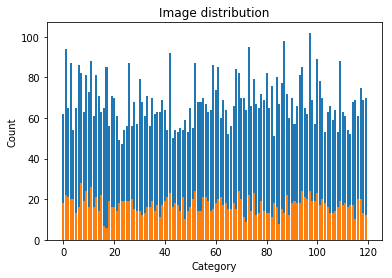

In [7]:
#count the number of each label
train_label_bin = []
val_label_bin = []

for i in xrange(len(unique_label)):
    train_label_bin.append(np.sum(train_labels[:, 1] == i))
    #print 'label: {}\tcount: {}'.format(i, np.sum(labels[:, 1] == i))
print 'total labels for training: {}'.format(np.sum(train_label_bin))

for i in xrange(len(unique_label)):
    val_label_bin.append(np.sum(val_labels[:, 1] == i))
    #print 'label: {}\tcount: {}'.format(i, np.sum(labels[:, 1] == i))
print 'total labels for training: {}'.format(np.sum(val_label_bin))

plt.figure()
plt.subplot()
plt.bar(xrange(len(unique_label)), train_label_bin)
plt.subplot()
plt.bar(xrange(len(unique_label)), val_label_bin)
plt.title('Image distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [6]:
#convert dataset to lmdb format
!./dataset/create_lmdb.sh

Creating train lmdb...
I0430 17:23:48.429257 15262 convert_imageset.cpp:86] Shuffling data
I0430 17:23:48.695854 15262 convert_imageset.cpp:89] A total of 8177 images.
I0430 17:23:48.696141 15262 db_lmdb.cpp:35] Opened lmdb /home/xiaojun/kaggle/dog-breed-identification/dataset/train_lmdb
I0430 17:23:50.187275 15262 convert_imageset.cpp:147] Processed 1000 files.
I0430 17:23:51.671416 15262 convert_imageset.cpp:147] Processed 2000 files.
I0430 17:23:53.186734 15262 convert_imageset.cpp:147] Processed 3000 files.
I0430 17:23:54.675276 15262 convert_imageset.cpp:147] Processed 4000 files.
I0430 17:23:56.101904 15262 convert_imageset.cpp:147] Processed 5000 files.
I0430 17:23:57.572196 15262 convert_imageset.cpp:147] Processed 6000 files.
I0430 17:23:59.027475 15262 convert_imageset.cpp:147] Processed 7000 files.
I0430 17:24:00.489850 15262 convert_imageset.cpp:147] Processed 8000 files.
I0430 17:24:00.778066 15262 convert_imageset.cpp:153] Processed 8177 files.
Creating val lmdb...
I0430 

In [5]:
#define classification network based on VGG16
from caffe import layers as L, params as P

TRAIN_LMDB = dataset_dir + 'train_lmdb'
VAL_LMDB = dataset_dir + 'val_lmdb'

def conv_relu(bottom, nout, ks = 3, stride = 1, pad = 1):
    conv = L.Convolution(bottom, num_output = nout, pad = pad, kernel_size = ks, stride = stride,
                         param=[dict(lr_mult = 0, decay_mult = 1), dict(lr_mult = 0, decay_mult = 0)])
    relu = L.ReLU(conv, in_place=True)
    return conv, relu

def max_pool(bottom, ks = 2, stride = 2):
    return L.Pooling(bottom, pool = P.Pooling.MAX, kernel_size = ks, stride = stride)

def fc_relu(bottom, nout):
    fc = L.InnerProduct(bottom, num_output = nout)
    relu = L.ReLU(fc, in_place = True)
    return fc, relu

def dog_net(mode):
    n = caffe.NetSpec()
    if mode == 'train':
        n.data, n.label = L.Data(name = 'data', source=TRAIN_LMDB, batch_size = 64, backend = P.Data.LMDB, ntop = 2,
                                 transform_param = dict(mirror = True, mean_value = [104, 117, 123], crop_size = 224))
    elif mode == 'val':
        n.data, n.label = L.Data(name = 'data', source=VAL_LMDB, batch_size = 32, backend = P.Data.LMDB, ntop = 2,
                                 transform_param = dict(mirror = False, mean_value = [104, 117, 123], crop_size = 224))
    else:
        print "unknown mode: only support 'train' and 'val' mode"
    
    #Convolution Net
    n.conv1_1, n.relu1_1 = conv_relu(n.data, 64)
    n.conv1_2, n.relu1_2 = conv_relu(n.relu1_1, 64)
    n.pool1 = max_pool(n.relu1_2)
    
    n.conv2_1, n.relu2_1 = conv_relu(n.pool1, 128)
    n.conv2_2, n.relu2_2 = conv_relu(n.relu2_1, 128)
    n.pool2 = max_pool(n.relu2_2)

    n.conv3_1, n.relu3_1 = conv_relu(n.pool2, 256)
    n.conv3_2, n.relu3_2 = conv_relu(n.relu3_1, 256)
    n.conv3_3, n.relu3_3 = conv_relu(n.relu3_2, 256)
    n.pool3 = max_pool(n.relu3_3)

    n.conv4_1, n.relu4_1 = conv_relu(n.pool3, 512)
    n.conv4_2, n.relu4_2 = conv_relu(n.relu4_1, 512)
    n.conv4_3, n.relu4_3 = conv_relu(n.relu4_2, 512)
    n.pool4 = max_pool(n.relu4_3)

    n.conv5_1, n.relu5_1 = conv_relu(n.pool4, 512)
    n.conv5_2, n.relu5_2 = conv_relu(n.relu5_1, 512)
    n.conv5_3, n.relu5_3 = conv_relu(n.relu5_2, 512)
    n.pool5 = max_pool(n.relu5_3)
    
    #Fully Connected
    n.fc6, n.relu6 =  fc_relu(n.pool5, 4096)
    n.drop6 = L.Dropout(n.relu6, dropout_ratio = 0.5, in_place=True)
    n.fc7, n.relu7 = fc_relu(n.drop6, 4096)
    n.drop7 = L.Dropout(n.relu7, dropout_ratio = 0.5, in_place=True)
    
    n.score = L.InnerProduct(n.drop7, num_output = 120)
    n.loss = L.SoftmaxWithLoss(n.score, n.label)
    
    if mode == 'val':
        n.accuracy1 = L.Accuracy(n.score, n.label, top_k = 1)
        n.accuracy5 = L.Accuracy(n.score, n.label, top_k = 5)
    return n.to_proto()
    
with open('train.prototxt', 'w') as f:
    f.write(str(dog_net('train')))
with open('val.prototxt', 'w') as f:
    f.write(str(dog_net('val')))

In [8]:
! cat train.prototxt
! cat val.prototxt

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    mirror: true
    crop_size: 224
    mean_value: 104.0
    mean_value: 117.0
    mean_value: 123.0
  }
  data_param {
    source: "dataset/train_lmdb"
    batch_size: 64
    backend: LMDB
  }
}
layer {
  name: "conv1_1"
  type: "Convolution"
  bottom: "data"
  top: "conv1_1"
  param {
    lr_mult: 0.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 0.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 64
    pad: 1
    kernel_size: 3
    stride: 1
  }
}
layer {
  name: "relu1_1"
  type: "ReLU"
  bottom: "conv1_1"
  top: "conv1_1"
}
layer {
  name: "conv1_2"
  type: "Convolution"
  bottom: "conv1_1"
  top: "conv1_2"
  param {
    lr_mult: 0.0
    decay_mult: 1.0
  }
  param {
    lr_mult: 0.0
    decay_mult: 0.0
  }
  convolution_param {
    num_output: 64
    pad: 1
    kernel_size: 3
    stride: 1
  }
}
layer {
  name: "relu1_2"
  type: "ReLU"
  bottom: "conv1_2"
  top: "conv1_2"
}
lay

In [9]:
#define solver.prototxt
def create_solver():
    solver = caffe.proto.caffe_pb2.SolverParameter()
    solver.train_net = "train.prototxt"
    solver.test_net.append("val.prototxt")
    solver.test_iter.append(200)
    solver.test_interval = 10
    solver.type = 'SGD'
    solver.base_lr = 0.001
    solver.lr_policy = "step"
    solver.gamma = 0.1
    solver.stepsize = 400
    solver.momentum = 0.9
    solver.weight_decay = 0.0005
    solver.display = 1000
    solver.max_iter = 2000
    solver.snapshot = 1000
    solver.solver_mode = P.Solver.GPU
    solver.snapshot_prefix = "snapshot"
    return solver

with open("solver.prototxt", "w") as f:
    f.write(str(create_solver()))

In [10]:
!cat solver.prototxt

train_net: "train.prototxt"
test_net: "val.prototxt"
test_iter: 200
test_interval: 10
base_lr: 0.0010000000475
display: 1000
max_iter: 2000
lr_policy: "step"
gamma: 0.10000000149
momentum: 0.899999976158
weight_decay: 0.000500000023749
stepsize: 400
snapshot: 1000
snapshot_prefix: "snapshot"
solver_mode: GPU
type: "SGD"


In [ ]:
#load pretrained VGG16 models and fine tune with training dataset
WEIGHTS = '/home/intel/models/caffemodels/vgg16.caffemodel'
niters = 5000

caffe.set_mode_gpu()

solver = caffe.get_solver('solver.prototxt')
solver.net.copy_from(WEIGHTS)

loss = np.zeros(niters)
acc = np.zeros(niters / 10)

for i in xrange(niters):
    solver.step(1)
    loss[i] = solver.net.blobs['loss'].data.copy()
    
    if i % 10 == 0:
        acc[i / 10] = solver.test_nets[0].blobs['accuracy5'].data.copy()
        print 'Iteration: {}\tloss: {}\taccuracy: {}'.format(i, loss[i], acc[i / 10])

Iteration: 0	loss: 4.7874917984	accuracy: 0.10000000149
Iteration: 10	loss: 3.98914813995	accuracy: 0.20000000298
Iteration: 20	loss: 2.61883306503	accuracy: 0.600000023842
Iteration: 30	loss: 1.90546321869	accuracy: 1.0
Iteration: 40	loss: 1.76009678841	accuracy: 0.899999976158
Iteration: 50	loss: 1.90112447739	accuracy: 0.800000011921
Iteration: 60	loss: 1.07464146614	accuracy: 1.0
Iteration: 70	loss: 1.38641810417	accuracy: 0.899999976158
Iteration: 80	loss: 1.31994128227	accuracy: 1.0
Iteration: 90	loss: 1.0538444519	accuracy: 1.0
Iteration: 100	loss: 1.25072169304	accuracy: 0.800000011921
Iteration: 110	loss: 1.31045234203	accuracy: 1.0
Iteration: 120	loss: 1.33082687855	accuracy: 0.899999976158
Iteration: 130	loss: 0.760771691799	accuracy: 0.899999976158
Iteration: 140	loss: 0.922671914101	accuracy: 1.0
Iteration: 150	loss: 0.981439828873	accuracy: 0.899999976158
Iteration: 160	loss: 0.787468850613	accuracy: 0.899999976158
Iteration: 170	loss: 1.02185499668	accuracy: 0.8999999761

In [3]:
#evaluation

# Helper function for deprocessing preprocessed images, e.g., for display.
def deprocess_net_image(image):
    image = image.copy()              # don't modify destructively
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    image += [123, 117, 104]          # (approximately) undo mean subtraction

    # clamp values in [0, 255]
    image[image < 0], image[image > 255] = 0, 255

    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)

    return image

trained_weights = '/home/xiaojun/kaggle/dog-breed-identification/snapshot_iter_1000.caffemodel'
net = caffe.Net('val.prototxt', trained_weights, caffe.TEST)
net.forward()

{'accuracy1': array(0.6875, dtype=float32),
 'accuracy5': array(0.9375, dtype=float32),
 'loss': array(1.4200338, dtype=float32)}

In [6]:
trained_weights = '/home/xiaojun/kaggle/dog-breed-identification/snapshot_iter_2000.caffemodel'
net = caffe.Net('val.prototxt', trained_weights, caffe.TEST)
net.forward()

{'accuracy1': array(0.6875, dtype=float32),
 'accuracy5': array(0.9375, dtype=float32),
 'loss': array(1.4257982, dtype=float32)}

In [14]:
mask = np.zeros(32)

for i in xrange(32):
    image = net.blobs['data'].data[i]
    label = net.blobs['label'].data[i]
    prediction = net.blobs['score'].data[i]
    if int(label) == prediction.argmax():
        mask[i] = True
    else:
        mask[i] = False
        #plt.imshow(deprocess_net_image(image))
        print 'label is %d, but the prediction is %d' %(int(label), prediction.argmax())
print 'true prediction count: %d' %(mask.sum())

label is 91, but the prediction is 15
label is 43, but the prediction is 101
label is 47, but the prediction is 67
label is 66, but the prediction is 80
label is 20, but the prediction is 58
label is 109, but the prediction is 83
label is 42, but the prediction is 5
label is 34, but the prediction is 44
label is 29, but the prediction is 87
label is 52, but the prediction is 67
true prediction count: 22


In [21]:
#define deploy.prototxt
from caffe import layers as L, params as P

def dog_deploy_net():
    
    n = caffe.NetSpec()
    
    n.data = L.Input(shape = dict(dim = [1, 3, 224, 224]))
    
    #Convolution Net
    n.conv1_1, n.relu1_1 = conv_relu(n.data, 64)
    n.conv1_2, n.relu1_2 = conv_relu(n.relu1_1, 64)
    n.pool1 = max_pool(n.relu1_2)
    
    n.conv2_1, n.relu2_1 = conv_relu(n.pool1, 128)
    n.conv2_2, n.relu2_2 = conv_relu(n.relu2_1, 128)
    n.pool2 = max_pool(n.relu2_2)

    n.conv3_1, n.relu3_1 = conv_relu(n.pool2, 256)
    n.conv3_2, n.relu3_2 = conv_relu(n.relu3_1, 256)
    n.conv3_3, n.relu3_3 = conv_relu(n.relu3_2, 256)
    n.pool3 = max_pool(n.relu3_3)

    n.conv4_1, n.relu4_1 = conv_relu(n.pool3, 512)
    n.conv4_2, n.relu4_2 = conv_relu(n.relu4_1, 512)
    n.conv4_3, n.relu4_3 = conv_relu(n.relu4_2, 512)
    n.pool4 = max_pool(n.relu4_3)

    n.conv5_1, n.relu5_1 = conv_relu(n.pool4, 512)
    n.conv5_2, n.relu5_2 = conv_relu(n.relu5_1, 512)
    n.conv5_3, n.relu5_3 = conv_relu(n.relu5_2, 512)
    n.pool5 = max_pool(n.relu5_3)
    
    #Fully Connected
    n.fc6, n.relu6 =  fc_relu(n.pool5, 4096)
    n.drop6 = L.Dropout(n.relu6, dropout_ratio = 0.5, in_place=True)
    n.fc7, n.relu7 = fc_relu(n.drop6, 4096)
    n.drop7 = L.Dropout(n.relu7, dropout_ratio = 0.5, in_place=True)
    
    n.score = L.InnerProduct(n.drop7, num_output = 120)
    n.prob = L.Softmax(n.score)
    return n.to_proto()

with open('deploy.prototxt', 'w') as f:
    f.write(str(dog_deploy_net()))

In [45]:
# load the trained model for inference

deploy_net = caffe.Net('deploy.prototxt', trained_weights, caffe.TEST)

In [56]:
# run inference on testset

mean_file = '/home/xiaojun/kaggle/dog-breed-identification/dataset/ilsvrc_2012_mean.npy'


transformer = caffe.io.Transformer({'data': deploy_net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.load(mean_file).mean(1).mean(1))
transformer.set_raw_scale('data', 255)
transformer.set_channel_swap('data', (2, 1, 0))

In [121]:
image_list = os.listdir(test_set)
num_test_image = len(image_list)
result_df = pd.DataFrame(columns=unique_label)
file_name_list = []

for i in xrange(num_test_image):
    image_path = test_set + image_list[i]
    image = caffe.io.load_image(image_path)
    transformed_image = transformer.preprocess('data', image)
    deploy_net.blobs['data'].data[...] = transformed_image
    deploy_net.forward()
    prob = deploy_net.blobs['prob'].data[0]
    #out = deploy_net.blobs['prob'].data[0].argmax()
    file_name, ext = os.path.splitext(image_list[i])
    file_name_list.append(file_name)
    
    item = pd.Series(np.array(prob), index=unique_label)
    result_df = result_df.append(item, ignore_index=True)

fn_df = pd.DataFrame(file_name_list, columns=['id'])
result_df = pd.concat([fn_df, result_df], axis=1)

result_df.to_csv('result.csv', index=False)